# Extra Metrics

Gorodetskaya et al. (2021) resalta la importancia de rolling mean

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('../data/aggregated_data_extra_metrics.csv')

In [3]:
data.head()

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Type,Weekday,Holiday Sequence,isYesterdayHoliday,isHoliday,isTomorrowHoliday,isYesterdayWeekday,isTomorrowWeekday,isWeekday,isPaymentDay,isPayweek,rolling_mean_weekday,rolling_max,lag_6,rolling_max_weekday,rolling_std,rolling_mean
0,Big Street ATM,2020-01-01,125,26,99,429200,75500,353700,Restricted Holiday,WEDNESDAY,WHH,False,True,True,True,True,True,False,True,429200.0,429200,429200.0,429200.0,110305.974453,2.988000e+05
1,Mount Road ATM,2020-01-01,144,49,95,377900,155200,222700,Restricted Holiday,WEDNESDAY,WHH,False,True,True,True,True,True,False,True,377900.0,983100,377900.0,377900.0,220819.202064,4.999467e+05
2,Airport ATM,2020-01-01,78,58,20,315400,269100,46300,Restricted Holiday,WEDNESDAY,WHH,False,True,True,True,True,True,False,True,315400.0,1034000,315400.0,315400.0,272711.985435,5.019806e+05
3,KK Nagar ATM,2020-01-01,268,176,92,1290200,927700,362500,Restricted Holiday,WEDNESDAY,WHH,False,True,True,True,True,True,False,True,1290200.0,1710500,1290200.0,1290200.0,289313.606662,1.059403e+06
4,Christ College ATM,2020-01-01,95,39,56,427100,235700,191400,Restricted Holiday,WEDNESDAY,WHH,False,True,True,True,True,True,False,True,427100.0,748100,427100.0,427100.0,146317.422066,4.707613e+05


## RIDGE - LASSO - ELASTICNET (OPTUNA)

In [30]:
combined_data = pd.read_csv('../data/aggregated_data_extra_metrics.csv ')
combined_data.drop(['No Of Withdrawals', 'No Of XYZ Card Withdrawals', 'No Of Other Card Withdrawals', 
                    'Amount withdrawn XYZ Card', 'Amount withdrawn Other Card',
                    'Type'], axis=1, inplace=True)

combined_data['Transaction Date'] = pd.to_datetime(combined_data['Transaction Date'])
combined_data['Day'] = combined_data['Transaction Date'].dt.day
combined_data['Month'] = combined_data['Transaction Date'].dt.month
combined_data['Year'] = combined_data['Transaction Date'].dt.year
combined_data.drop('Transaction Date', axis=1, inplace=True)

In [31]:
atm_names = combined_data['ATM Name'].unique()

In [32]:
categorical_features_list = ['Weekday', 'Holiday Sequence', 
                             'Month', 'Day', 'Year']

In [34]:
def convert_categorical_to_numerical(data, column_list):
    if 'ATM Name' in column_list:
        column_list.remove('ATM Name')
        temp_data = pd.get_dummies(data, columns=column_list , drop_first=True)
    
        # Do drop_first for all columns, except for ATM Name, because it becomes useful for accessing individual ATM test
        # data later on
        return pd.get_dummies(temp_data, columns=['ATM Name'])
    else:
        return pd.get_dummies(data, columns=column_list, drop_first=True)

In [ ]:
import optuna
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import numpy as np
from scipy import stats

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Función objective para Optuna
def objective(trial, model_type, X_train, y_train, X_test, y_test):
    # Sugerir el valor de alpha usando logspace para ajustarlo
    alpha = trial.suggest_float("alpha", 1e-3, 10, log=True)
    
    if model_type == "lasso":
        model = Lasso(alpha=alpha, max_iter=2000)
    elif model_type == "ridge":
        model = Ridge(alpha=alpha)
    elif model_type == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=2000)
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir y calcular el RMSE en los datos de prueba
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse  # Optuna minimiza este valor

# Función principal modificada para utilizar Optuna
def model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, 
                                      model_type, n_trials=50, tree_model='Invalid'):
    
    # Convertir datos categóricos a numéricos (función existente)
    curr_atm_data = new_data[new_data['ATM Name'] == atm_name].drop('ATM Name', axis=1)
    numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)
    
    X = numeric_curr_atm_data.drop('Total amount Withdrawn', axis=1)
    y = numeric_curr_atm_data['Total amount Withdrawn']
    
    # Dividir datos secuencialmente en 70% entrenamiento y 30% prueba
    train_size = int(0.7 * len(X))
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    
    # Crear un estudio con Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, model_type, X_train, y_train, X_test, y_test), n_trials=n_trials)
    
    # Obtener el mejor modelo y sus hiperparámetros
    best_params = study.best_params
    print("Mejores Hiperparámetros:\n", best_params)
    print("Mejor CV RMSE:", study.best_value)
    
    # Crear el modelo con los mejores parámetros
    if model_type == "lasso":
        best_model = Lasso(alpha=best_params['alpha'], max_iter=2000)
    elif model_type == "ridge":
        best_model = Ridge(alpha=best_params['alpha'])
    elif model_type == "elasticnet":
        best_model = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'], max_iter=2000)
    
    # Entrenar el mejor modelo en los datos de entrenamiento
    best_model.fit(X_train, y_train)
    
    # Hacer predicciones y calcular métricas en el conjunto de prueba
    model_predictions = best_model.predict(X_test)
    model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
    model_mape = mean_absolute_percentage_error(y_test, model_predictions)
    
    print("Test RMSE:", model_rmse)
    print("Test MAPE:", model_mape)
    
    # Permitir análisis de importancia de características solo para modelos de árboles
    column_names = X_train.columns
    if tree_model == False:
        # Mostrar coeficientes con valores p para modelos lineales
        try:
            p_val_array = stats.coef_pval(best_model, X_train, y_train)
            [print("{} : {}".format(x, y)) for x, y in zip(column_names, p_val_array[1:]) if y < 0.05]
        except:
            pass
        
    elif tree_model == True:
        r = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=0)
        for i in r.importances_mean.argsort()[::-1]:
            if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
                print(f"{column_names[i]:<8}: "
                      f"{r.importances_mean[i]:.3f}"
                      f" +/- {r.importances_std[i]:.3f}")
        
    print("------------------------------------------------------------------------\n")



In [36]:
# Nombre del cajero automático que deseas probar
atm_name = "Big Street ATM"

# Probar el modelo Lasso para este cajero automático
model_training_hyperparam_per_atm(atm_name, combined_data, categorical_features_list, model_type='lasso', n_trials=50)

[I 2024-09-26 22:07:50,322] A new study created in memory with name: no-name-f7a621b0-cb18-418a-b703-ad4d59221fcc
c:\Users\edurz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.981e+12, tolerance: 1.668e+09
  model = cd_fast.enet_coordinate_descent(
[I 2024-09-26 22:07:50,419] Trial 0 finished with value: 127919.78968005904 and parameters: {'alpha': 0.09522557370165434}. Best is trial 0 with value: 127919.78968005904.
c:\Users\edurz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.519e+12, tolerance: 1.6

Mejores Hiperparámetros:
 {'alpha': 9.983708853294553}
Mejor CV RMSE: 127849.00105195855
Test RMSE: 127849.00105195855
Test MAPE: 364.80645978062034
------------------------------------------------------------------------



In [37]:
# Si quieres probar Ridge
model_training_hyperparam_per_atm(atm_name, combined_data, categorical_features_list, model_type='ridge', n_trials=50)

[I 2024-09-26 22:07:54,314] A new study created in memory with name: no-name-d71483ef-ba3e-413e-a3fd-2f8236c5098e
[I 2024-09-26 22:07:54,319] Trial 0 finished with value: 127607.2969902256 and parameters: {'alpha': 1.4645459650085866}. Best is trial 0 with value: 127607.2969902256.
[I 2024-09-26 22:07:54,325] Trial 1 finished with value: 127579.60001401165 and parameters: {'alpha': 1.6591735589305148}. Best is trial 1 with value: 127579.60001401165.
[I 2024-09-26 22:07:54,330] Trial 2 finished with value: 127886.98142161414 and parameters: {'alpha': 0.057826545463279234}. Best is trial 1 with value: 127579.60001401165.
[I 2024-09-26 22:07:54,335] Trial 3 finished with value: 127789.02245298278 and parameters: {'alpha': 0.3704781885688207}. Best is trial 1 with value: 127579.60001401165.
[I 2024-09-26 22:07:54,341] Trial 4 finished with value: 127719.07147520999 and parameters: {'alpha': 0.7437464356707217}. Best is trial 1 with value: 127579.60001401165.
[I 2024-09-26 22:07:54,345] Tri

Mejores Hiperparámetros:
 {'alpha': 9.92302640585168}
Mejor CV RMSE: 126852.30714469914
Test RMSE: 126852.30714469914
Test MAPE: 352.2146742247775
------------------------------------------------------------------------



In [38]:
# Si quieres probar ElasticNet
model_training_hyperparam_per_atm(atm_name, combined_data, categorical_features_list, model_type='elasticnet', n_trials=50)

[I 2024-09-26 22:07:54,722] A new study created in memory with name: no-name-31ae9c59-b027-4fad-bcff-def1185be553
[I 2024-09-26 22:07:54,733] Trial 0 finished with value: 126232.18287409915 and parameters: {'alpha': 1.8004319245155245, 'l1_ratio': 0.3012669530429579}. Best is trial 0 with value: 126232.18287409915.
[I 2024-09-26 22:07:54,761] Trial 1 finished with value: 127174.16162317654 and parameters: {'alpha': 0.005016272327166379, 'l1_ratio': 0.06351803887594532}. Best is trial 0 with value: 126232.18287409915.
[I 2024-09-26 22:07:54,773] Trial 2 finished with value: 126766.77702326671 and parameters: {'alpha': 0.018464224815306553, 'l1_ratio': 0.4492457255548902}. Best is trial 0 with value: 126232.18287409915.
[I 2024-09-26 22:07:54,790] Trial 3 finished with value: 127052.3741882239 and parameters: {'alpha': 0.014423267154527838, 'l1_ratio': 0.5827815749390027}. Best is trial 0 with value: 126232.18287409915.
[I 2024-09-26 22:07:54,795] Trial 4 finished with value: 126287.0122

Mejores Hiperparámetros:
 {'alpha': 0.2447036589309013, 'l1_ratio': 0.5654231705161497}
Mejor CV RMSE: 126065.29686579591
Test RMSE: 126065.29686579591
Test MAPE: 318.65610741004696
------------------------------------------------------------------------



In [41]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, ElasticNet
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, validation_curve, cross_val_score, train_test_split

In [42]:
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, balanced_accuracy_score

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Works for both RandomizedSearchCV() object and GridSearchCV() object
def model_training_hyperparam_per_atm(atm_name, new_data, categorical_features_list, 
                                      param_cv_obj, tree_model='Invalid'):
    
    curr_atm_data = new_data[new_data['ATM Name'] == atm_name].drop('ATM Name', axis=1)
    numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)
    
    # Dropping Correlated Holiday Sequence columns (only temporarily used)
    # numeric_curr_atm_data.drop(['Holiday Sequence_HWW','Holiday Sequence_WHH','Holiday Sequence_HHW'], axis=1,inplace=True)
    
    # Not using 2016 and 2017 data so that testing can be done better
    # numeric_curr_atm_data = numeric_curr_atm_data[numeric_curr_atm_data.apply(lambda x: x['Year_2016'] != 1 and x['Year_2017'] != 1, axis=1)]
    
    X = numeric_curr_atm_data.drop('Total amount Withdrawn', axis=1)
    y = numeric_curr_atm_data['Total amount Withdrawn']
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
    # Splitting data sequentially as 70% train and 30% test
    train_size = int(0.7 * len(X))
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    
    param_cv_obj.fit(X_train, y_train)
    print("Best Parameters:\n", param_cv_obj.best_params_)
    print("\nBest CV RMSE:", -param_cv_obj.best_score_)
    
    if 'mean_train_score' in param_cv_obj.cv_results_:
        # nanmean() is used here instead of mean() because for DecisionTree the mean_train_score actually contains nan
        # for some reason, so nanmean() ignores it while computing mean
        print("Best Training RMSE:", -np.nanmean(param_cv_obj.cv_results_['mean_train_score']))
    
    best_model = param_cv_obj.best_estimator_
    model_predictions = best_model.predict(X_test)
    model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
    model_mape = mean_absolute_percentage_error(y_test, model_predictions)
    
    print("Test RMSE:", model_rmse)
    print("Test MAPE:", model_mape)
    
    column_names = X_train.columns
    
    if tree_model == False:
        # p_val_array[1:] because 0-th index is reserved for intercept p-val which is not required for us
        try:
            p_val_array = stats.coef_pval(best_model, X_train, y_train)
            [print("{} : {}".format(x, y)) for x, y in zip(column_names, p_val_array[1:]) if y < 0.05]
        except:
            pass
        
    elif tree_model == True:
        r = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=0)
        for i in r.importances_mean.argsort()[::-1]:
            if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
                print(f"{column_names[i]:<8}: "
                      f"{r.importances_mean[i]:.3f}"
                      f" +/- {r.importances_std[i]:.3f}")
        
    print("------------------------------------------------------------------------\n")    

In [43]:
lasso_param_grid = {'alpha':np.logspace(-3, 3, num=50)}
grid_cv_lasso = GridSearchCV(Lasso(max_iter=2000), lasso_param_grid, verbose=2, n_jobs=-1, 
                             scoring='neg_root_mean_squared_error', cv=10, return_train_score=True)

for atm_name in atm_names:
    print("\nFor", atm_name)
    model_training_hyperparam_per_atm(atm_name, combined_data, categorical_features_list, 
                                      grid_cv_lasso, tree_model=False)


For Big Street ATM
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Parameters:
 {'alpha': 79.06043210907701}

Best CV RMSE: 98412.12708499379
Best Training RMSE: 93744.1966143987
Test RMSE: 127166.68370325981
Test MAPE: 358.64450199274603
------------------------------------------------------------------------


For Mount Road ATM
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Parameters:
 {'alpha': 184.20699693267164}

Best CV RMSE: 167093.74745748332
Best Training RMSE: 157370.53588908596
Test RMSE: 171861.5370585407
Test MAPE: 461.3388747215967
------------------------------------------------------------------------


For Airport ATM
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Parameters:
 {'alpha': 568.9866029018293}

Best CV RMSE: 157366.44271727937
Best Training RMSE: 149660.09305361088
Test RMSE: 162555.12122861098
Test MAPE: 453.22537619605157
----------------------------------------------------------------------

In [49]:
curr_atm_data = combined_data[combined_data['ATM Name'] == "Christ College ATM"].drop('ATM Name', axis=1)
numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)

# Dropping Correlated Holiday Sequence columns (only temporarily used)
# numeric_curr_atm_data.drop(['Holiday Sequence_HWW','Holiday Sequence_WHH','Holiday Sequence_HHW'], axis=1,inplace=True)

# Not using 2016 and 2017 data so that testing can be done better
# numeric_curr_atm_data = numeric_curr_atm_data[numeric_curr_atm_data.apply(lambda x: x['Year_2016'] != 1 and x['Year_2017'] != 1, axis=1)]

X = numeric_curr_atm_data.drop('Total amount Withdrawn', axis=1)
y = numeric_curr_atm_data['Total amount Withdrawn']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
# Splitting data sequentially as 70% train and 30% test
train_size = int(0.7 * len(X))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

{'Lagrange multiplier statistic': 157.45554896403138, 'p-value': 2.5542325139907617e-08, 'f-value': 3.2080696237510637, 'f p-value': 1.0429465830773217e-12}
{'Lagrange multiplier statistic': 486.93690795455484, 'p-value': 5.4769615642700444e-06, 'f-value': 2788.8141953295008, 'f p-value': 8.704443562745431e-192}
Mean Absolute Percentage Error (MAPE): 4.07%
Mean Absolute Error (MAE): 222643.92112528984
Mean Squared Error (MSE): 77254623067.10323
Root Mean Squared Error (RMSE): 277947.15876781906


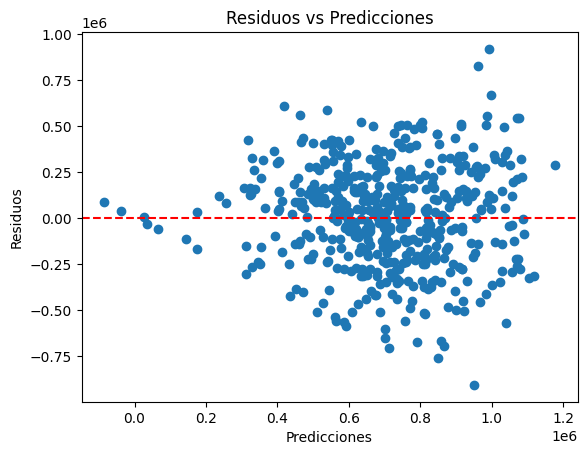

C:\Users\edurz\AppData\Local\Temp\ipykernel_26312\4217798619.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


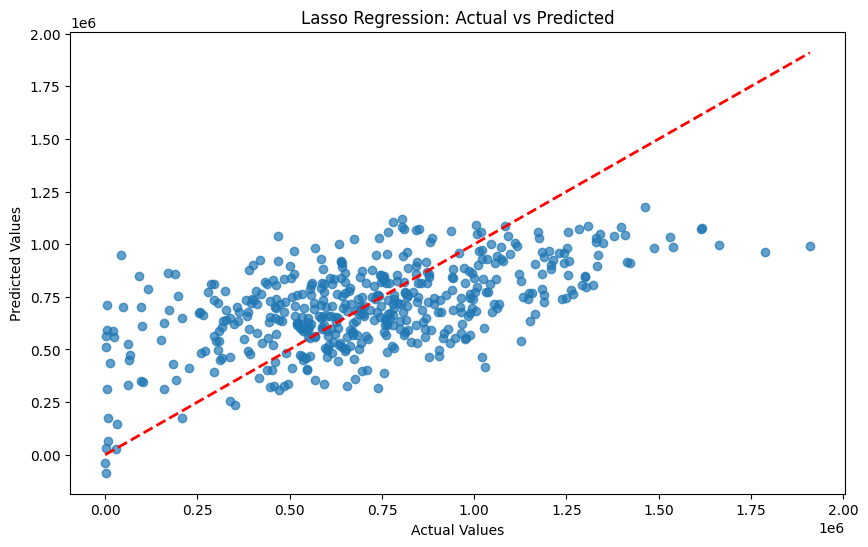

In [54]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

model = Lasso(alpha=244.205309454865)

# Entrenar el modelo con los mejores hiperparámetros
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular MAPE, MAE, MSE y RMSE
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


############## homocedasticidad 
residuals = y_test - y_pred
# Agregar una constante a las variables independientes para la prueba
X_test_with_const = sm.add_constant(X_test)
# Aplicar la prueba de Breusch-Pagan
bp_test = het_breuschpagan(residuals, X_test_with_const)
# La salida contiene: el estadístico de la prueba, p-value, f-statistic, f-p-value
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))
# p-value: Si el p-value es pequeño (menor a 0.05 en general), podemos rechazar la hipótesis nula de homocedasticidad, lo que indica heterocedasticidad (es decir, la varianza de los residuos no es constante).
# f-value: Este valor se usa como parte de la estadística para contrastar la hipótesis.

# Aplicar la prueba de White
white_test = het_white(residuals, X_test_with_const)
# La salida contiene: el estadístico de la prueba, p-value, f-statistic, f-p-value
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, white_test)))
# Similar a la prueba de Breusch-Pagan, la prueba de White verifica si hay heterocedasticidad en el modelo.
# p-value: Si el valor p es menor que 0.05, rechazamos la hipótesis nula de homocedasticidad.


# Mostrar los resultados
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


# Gráfico de los residuos contra las predicciones
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos vs Predicciones')
plt.show()




# Gráfico de valores predichos vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'{"Lasso"} Regression: Actual vs Predicted')
plt.show()

In [5]:
from sklearn.model_selection import KFold
from category_encoders import TargetEncoder
import pandas as pd

# Load your data here
# data = pd.read_csv('your_dataset.csv')

# Defining target and features
target = 'Total amount Withdrawn'
categorical_columns = ['Weekday', 'Holiday Sequence', 'ATM Name']

# Initialize the target encoder
encoder = TargetEncoder(cols=categorical_columns)

# Apply KFold for cross-validation to ensure target encoding avoids data leakage
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform target encoding
data_encoded = data_cleaned.copy()  # copy the cleaned data
data_encoded[categorical_columns] = 0  # Initialize to store encoded values

for train_index, test_index in kf.split(data_cleaned):
    train_data, test_data = data_cleaned.iloc[train_index], data_cleaned.iloc[test_index]
    
    # Fit the encoder on the training data only
    encoder.fit(train_data[categorical_columns], train_data[target])
    
    # Transform the test data and store it back in the encoded data
    data_encoded.iloc[test_index, data_encoded.columns.get_indexer(categorical_columns)] = encoder.transform(test_data[categorical_columns])

# Check the first few rows of the encoded data
print(data_encoded.head())


        ATM Name Transaction Date  Total amount Withdrawn        Weekday  \
0  374306.754658       2020-01-01                  429200  573223.995536   
1  503203.679477       2020-01-01                  377900  580701.635769   
2  430505.764411       2020-01-01                  315400  580701.635769   
3  779561.992337       2020-01-01                 1290200  573048.804348   
4  637712.208398       2020-01-01                  427100  573048.804348   

   Holiday Sequence  isYesterdayHoliday  isHoliday  isTomorrowHoliday  \
0     540244.295009               False       True               True   
1     508934.772933               False       True               True   
2     508934.772933               False       True               True   
3     518678.871279               False       True               True   
4     518678.871279               False       True               True   

   isYesterdayWeekday  isTomorrowWeekday  isWeekday  isPaymentDay  isPayweek  \
0                True   

C:\Users\edurz\AppData\Local\Temp\ipykernel_26312\2110673950.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[573223.99553571 568287.07557503 593249.61997828 ... 593249.61997828
 557634.16216216 557634.16216216]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_encoded.iloc[test_index, data_encoded.columns.get_indexer(categorical_columns)] = encoder.transform(test_data[categorical_columns])
C:\Users\edurz\AppData\Local\Temp\ipykernel_26312\2110673950.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[540244.29500928 566719.32938856 552558.83634779 ... 552558.83634779
 566072.28915663 566072.28915663]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_encoded.iloc[test_index, data_encoded.columns.get_indexer(categorical_columns)

In [7]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
import pandas as pd

# Prepare the data
X = data_encoded.drop(columns=[target, 'Transaction Date'])  # Remove the target and Transaction Date
y = data_encoded[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    model_type = trial.suggest_categorical("model_type", ["ridge", "lasso", "elasticnet"])
    
    if model_type == "ridge":
        alpha = trial.suggest_float("alpha", 0.1, 3, log=True)
        model = Ridge(alpha=alpha)
    
    elif model_type == "lasso":
        alpha = trial.suggest_float("alpha", 0.1, 3, log=True)
        model = Lasso(alpha=alpha)
    
    else:  # elasticnet
        alpha = trial.suggest_float("alpha", 0.1, 3, log=True)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Create an Optuna study and optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)

# Output the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print(f"  Params: {trial.params}")

[I 2024-09-26 20:32:43,087] A new study created in memory with name: no-name-caa3b2ea-1f27-408d-a05d-6916e8e95047
[I 2024-09-26 20:32:43,136] Trial 0 finished with value: 41152611241.60525 and parameters: {'model_type': 'elasticnet', 'alpha': 0.20188810183851366, 'l1_ratio': 0.6833926005153217}. Best is trial 0 with value: 41152611241.60525.
[I 2024-09-26 20:32:43,194] Trial 1 finished with value: 41163111741.59061 and parameters: {'model_type': 'elasticnet', 'alpha': 0.2575576876142391, 'l1_ratio': 0.1265887765199588}. Best is trial 0 with value: 41152611241.60525.
[I 2024-09-26 20:32:43,203] Trial 2 finished with value: 41152691490.09313 and parameters: {'model_type': 'ridge', 'alpha': 0.11902237770091982}. Best is trial 0 with value: 41152611241.60525.
[I 2024-09-26 20:32:43,253] Trial 3 finished with value: 41152835796.17773 and parameters: {'model_type': 'lasso', 'alpha': 0.12611252709137172}. Best is trial 0 with value: 41152611241.60525.
[I 2024-09-26 20:32:43,302] Trial 4 finis

Best trial:
  Value: 41135753297.84592
  Params: {'model_type': 'elasticnet', 'alpha': 0.1195757149688881, 'l1_ratio': 0.9397430012427511}


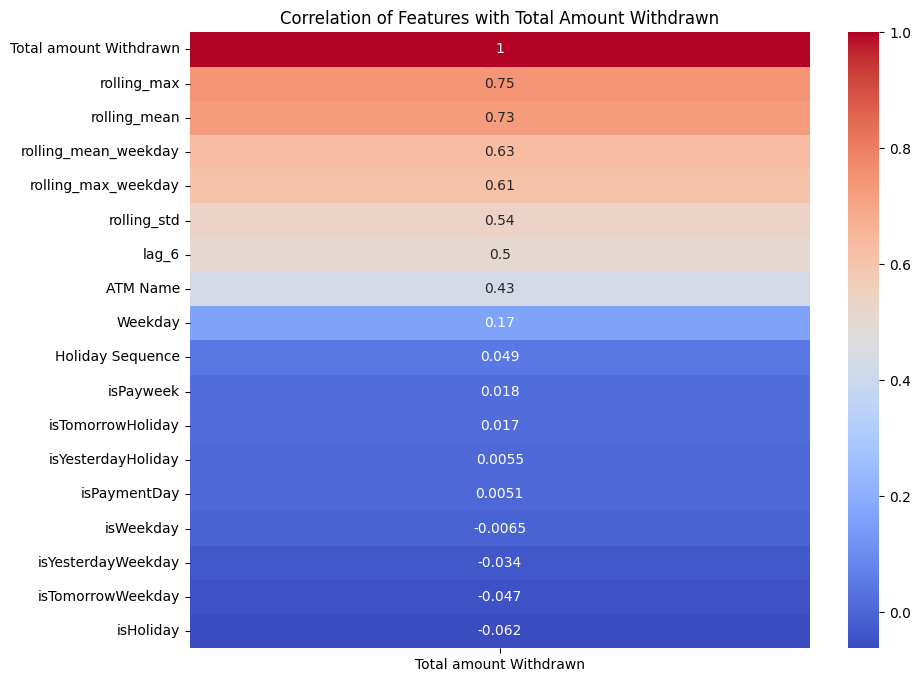

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

temp = data_encoded.drop(columns=['Transaction Date'])

# Calculate correlations
correlations = temp.corr()

# Display correlation with the target
plt.figure(figsize=(10, 8))
sns.heatmap(correlations[['Total amount Withdrawn']].sort_values(by='Total amount Withdrawn', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with Total Amount Withdrawn')
plt.show()

In [9]:
# Check for low variance features
low_variance = temp.var().sort_values(ascending=True).head(10)
print("Low variance features:\n", low_variance)


Low variance features:
 isPaymentDay          6.311030e-02
isHoliday             9.507340e-02
isYesterdayHoliday    9.695316e-02
isTomorrowHoliday     9.823271e-02
isYesterdayWeekday    2.023702e-01
isWeekday             2.042770e-01
isTomorrowWeekday     2.055088e-01
isPayweek             2.441776e-01
Holiday Sequence      5.422418e+08
Weekday               3.317721e+09
dtype: float64


In [10]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

# Use Ridge as the model for RFE
ridge = Ridge()

# Perform RFE to select top features
rfe = RFE(estimator=ridge, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get ranking of features
ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()
print("Feature rankings:\n", ranking)


Feature rankings:
 isWeekday               1
Weekday                 1
isYesterdayHoliday      1
isHoliday               1
isTomorrowHoliday       1
isYesterdayWeekday      1
isTomorrowWeekday       1
rolling_std             1
isPaymentDay            1
isPayweek               1
rolling_max             2
Holiday Sequence        3
rolling_mean            4
rolling_mean_weekday    5
ATM Name                6
lag_6                   7
rolling_max_weekday     8
dtype: int32


Mean Absolute Percentage Error (MAPE): 2.72%
Mean Absolute Error (MAE): 151579.04171980047
Mean Squared Error (MSE): 41135753297.84592
Root Mean Squared Error (RMSE): 202819.50916478896


C:\Users\edurz\AppData\Local\Temp\ipykernel_26312\2604087314.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


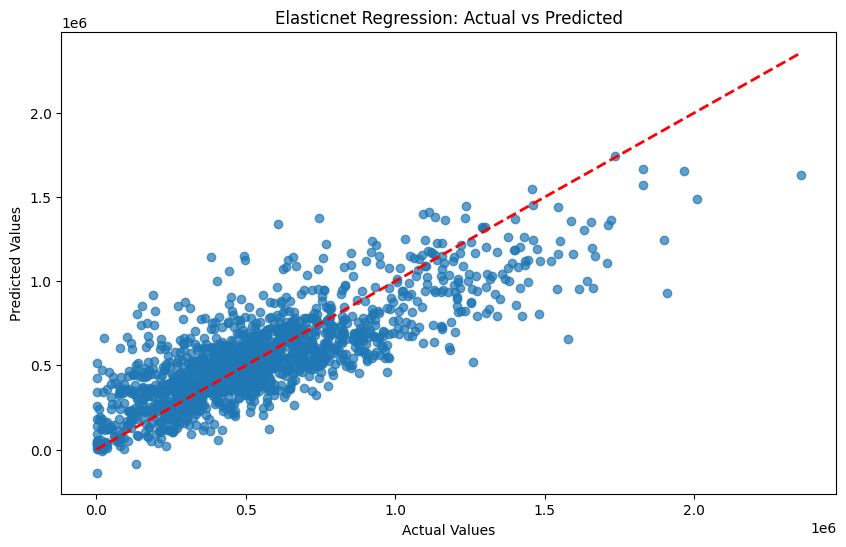

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# Asumimos que los mejores parámetros se obtuvieron con Optuna:
# Mejor modelo y parámetros obtenidos de Optuna
best_params = study.best_params  # Obtenido de tu proceso de optimización con Optuna

# Seleccionar el modelo basado en los mejores parámetros
if best_params['model_type'] == 'ridge':
    model = Ridge(alpha=best_params['alpha'])
elif best_params['model_type'] == 'lasso':
    model = Lasso(alpha=best_params['alpha'])
else:  # ElasticNet
    model = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'])

# Entrenar el modelo con los mejores hiperparámetros
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular MAPE, MAE, MSE y RMSE
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Mostrar los resultados
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Gráfico de valores predichos vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'{best_params["model_type"].capitalize()} Regression: Actual vs Predicted')
plt.show()
